In [ ]:
!pip install yfinance --upgrade --no-cache-dir     # install the latest version of yfinance to avoid rate limit error

In [ ]:
# Define the stock symbols for good and bad ESG companies
good_stocks = ['AAPL', 'JNJ', 'MSFT', 'V', 'NKE']
bad_stocks = ['META', 'CVX', 'SHEL', 'SE', 'BA']

# Combine both lists of stock symbols
all_stocks = good_stocks + bad_stocks

# Define a function to download the closing price data
def download_data(stocks, start_date, end_date):
    data = yf.download(stocks, start=start_date, end=end_date)['Close']
    return data

from scipy.stats.mstats import winsorize
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats

# Download data for the past 5 years
start_date = '2020-05-01'
end_date = '2025-05-01'

data = download_data(all_stocks, start_date, end_date)

# Calculate monthly returns
monthly_returns = data.resample('ME').ffill().pct_change().dropna()

# Define a function to Winsorize the data at 1% and 99% levels
def winsorize_data(df, lower_percentile=1, upper_percentile=99):
    lower_bound = np.percentile(df, lower_percentile, axis=0)
    upper_bound = np.percentile(df, upper_percentile, axis=0)
    df_winsorized = df.copy()
    df_winsorized[df < lower_bound] = lower_bound
    df_winsorized[df > upper_bound] = upper_bound
    return df_winsorized

monthly_returns_winsorized = monthly_returns.apply(winsorize_data, axis=0)
print(monthly_returns_winsorized)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed

Ticker          AAPL        BA       CVX       JNJ      META      MSFT  \
Date                                                                     
2020-06-30  0.147386  0.256771 -0.026935 -0.054588  0.008797  0.110559   
2020-07-31  0.165132 -0.138025 -0.059285  0.036479  0.117144  0.007371   
2020-08-31  0.200367  0.087468  0.014296  0.059489  0.155832  0.102752   
2020-09-30 -0.102526 -0.038180 -0.142142 -0.029529 -0.106753 -0.067396   
2020-10-31 -0.060012 -0.126286 -0.034722 -0.079057  0.004620 -0.037370   
2020-11-30  0.095493  0.341838  0.264894  0.062544  0.052678  0.060060   
2020-12-31  0.114574  0.015899 -0.031315  0.087780 -0.013756  0.039006   
2021-01-31 -0.005501 -0.092824  0.008881  0.036536 -0.054291  0.042892   
2021-02-28 -0.079712  0.091766  0.190300 -0.022571 -0.002748  0.004118   
2021-03-31  0.007340  0.201453  0.047900  0.037171  0.143273  0.014588   
2021-04-30  0.076218 -0.080127 -0.016414 -0.009857  0.103724  0.069602   
2021-05-31 -0.050497  0.054244  0.0193

In [ ]:
# Calculate expected return and standard deviation
geo_means = (monthly_returns_winsorized + 1).prod() ** (1/len(monthly_returns_winsorized)) -1
expected_returns = (1+geo_means) ** 12 - 1
std_devs = monthly_returns_winsorized.std()*np.sqrt(12)

# Combine results into a summary DataFrame
summary_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Standard Deviation': std_devs
})
print(summary_stats)

        Expected Return  Standard Deviation
Ticker                                     
AAPL           0.225012            0.279403
BA             0.033243            0.407557
CVX            0.131291            0.303646
JNJ            0.038417            0.165074
META           0.201552            0.407518
MSFT           0.178054            0.217676
NKE           -0.098010            0.317638
SE             0.130864            0.564879
SHEL           0.184260            0.241434
V              0.131667            0.223638


In [ ]:
# Covariance matrices for Good and Bad ESG groups
cov_good = monthly_returns_winsorized[good_stocks].cov() * 12
cov_bad = monthly_returns_winsorized[bad_stocks].cov() * 12

print("Covariance Matrix - Good ESG Group:\n", cov_good)
print("\nCovariance Matrix - Bad ESG Group:\n", cov_bad)

Covariance Matrix - Good ESG Group:
 Ticker      AAPL       JNJ      MSFT         V       NKE
Ticker                                                  
AAPL    0.078066  0.012601  0.040104  0.028951  0.040650
JNJ     0.012601  0.027249  0.005444  0.016100  0.016323
MSFT    0.040104  0.005444  0.047383  0.016415  0.032754
V       0.028951  0.016100  0.016415  0.050014  0.035807
NKE     0.040650  0.016323  0.032754  0.035807  0.100894

Covariance Matrix - Bad ESG Group:
 Ticker      META       CVX      SHEL        SE        BA
Ticker                                                  
META    0.166071 -0.017137 -0.008317  0.097341  0.028670
CVX    -0.017137  0.092201  0.054611  0.015481  0.036681
SHEL   -0.008317  0.054611  0.058290  0.001435  0.026396
SE      0.097341  0.015481  0.001435  0.319088  0.045056
BA      0.028670  0.036681  0.026396  0.045056  0.166103


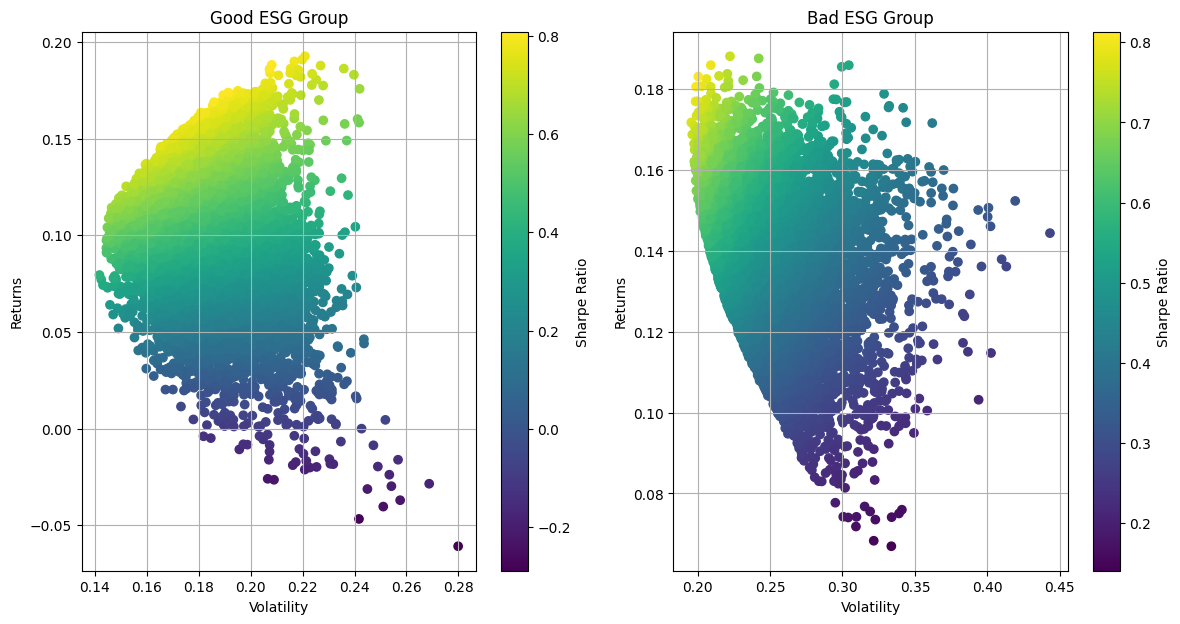

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

num_portfolios = 10000

# Function to generate random portfolios for a given group
def generate_portfolios(stocks, expected_returns, covariance_matrix, num_portfolios=10000):
    results = {
        'Return': [],
        'StdDev': [],
        'Sharpe Ratio': [],
        'Weights': []
    }

    # Generate random portfolios
    for _ in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)  # Normalize weights so they sum to 1

        # Calculate portfolio return
        portfolio_return = np.sum(weights * expected_returns[stocks])

        # Calculate portfolio standard deviation
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix.loc[stocks, stocks], weights)))

        # Calculate Sharpe ratio
        sharpe_ratio = (portfolio_return - 0.02) / portfolio_stddev

        results['Return'].append(portfolio_return)
        results['StdDev'].append(portfolio_stddev)
        results['Sharpe Ratio'].append(sharpe_ratio)
        results['Weights'].append(weights)

    # Convert results to DataFrame
    portfolios_df = pd.DataFrame(results)
    return portfolios_df

# Generate portfolios for Good and Bad ESG groups
portfolios_good = generate_portfolios(good_stocks, expected_returns, cov_good)
portfolios_bad = generate_portfolios(bad_stocks, expected_returns, cov_bad)

# Plotting the results with Sharpe ratio color mapping
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot for Good ESG Group
scatter_good = ax1.scatter(
    portfolios_good['StdDev'],
    portfolios_good['Return'],
    c=portfolios_good['Sharpe Ratio'],
    cmap='viridis',
    marker='o'
)
ax1.set_title('Good ESG Group')
ax1.set_xlabel('Volatility')
ax1.set_ylabel('Returns')
ax1.grid(True)

# Plot for Bad ESG Group
scatter_bad = ax2.scatter(
    portfolios_bad['StdDev'],
    portfolios_bad['Return'],
    c=portfolios_bad['Sharpe Ratio'],
    cmap='viridis',
    marker='o'
)
ax2.set_title('Bad ESG Group')
ax2.set_xlabel('Volatility')
ax2.set_ylabel('Returns')
ax2.grid(True)

# Add color bar to show Sharpe Ratio scale
fig.colorbar(scatter_good, ax=ax1, label='Sharpe Ratio')
fig.colorbar(scatter_bad, ax=ax2, label='Sharpe Ratio')

plt.show()

In [ ]:
import scipy.optimize as sco

# Function to calculate portfolio variance
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Function to find global minimum variance portfolio weights
def get_gmvp_weights(stock_list, cov_matrix):
    n = len(stock_list)
    init_guess = np.ones(n) / n
    bounds = tuple((0, 1) for _ in range(n))
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    result = sco.minimize(
        portfolio_variance,
        init_guess,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result.x

gmvp_weights_good = get_gmvp_weights(good_stocks, cov_good)
gmvp_return_good = np.dot(gmvp_weights_good, expected_returns[good_stocks])
gmvp_std_good = np.sqrt(np.dot(gmvp_weights_good.T, np.dot(cov_good, gmvp_weights_good)))

print("Good ESG - Global Minimum Variance Portfolio Weights:")
for stock, weight in zip(good_stocks, gmvp_weights_good):
    print(f"{stock}: {weight:.4f}")
print(f"Expected Return: {gmvp_return_good:.4f}")
print(f"Standard Deviation: {gmvp_std_good:.4f}")

gmvp_weights_bad = get_gmvp_weights(bad_stocks, cov_bad)
gmvp_return_bad = np.dot(gmvp_weights_bad, expected_returns[bad_stocks])
gmvp_std_bad = np.sqrt(np.dot(gmvp_weights_bad.T, np.dot(cov_bad, gmvp_weights_bad)))

print("\nBad ESG - Global Minimum Variance Portfolio Weights:")
for stock, weight in zip(bad_stocks, gmvp_weights_bad):
    print(f"{stock}: {weight:.4f}")
print(f"Expected Return: {gmvp_return_bad:.4f}")
print(f"Standard Deviation: {gmvp_std_bad:.4f}")


Good ESG - Global Minimum Variance Portfolio Weights:
AAPL: 0.0000
JNJ: 0.6015
MSFT: 0.3020
V: 0.0965
NKE: 0.0000
Expected Return: 0.0896
Standard Deviation: 0.1395

Bad ESG - Global Minimum Variance Portfolio Weights:
META: 0.2367
CVX: 0.0834
SHEL: 0.5790
SE: 0.0304
BA: 0.0705
Expected Return: 0.1717
Standard Deviation: 0.1954


In [ ]:
import scipy.optimize as sco
# Define Sharpe ratio to maximize (negative for minimization)
def neg_sharpe_ratio(weights, expected_returns, cov_matrix, rf):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return - rf) / portfolio_std  # Negative for minimization

# Function to get tangency portfolio weights
def get_tangency_weights(stock_list, expected_returns, cov_matrix, rf=0.02):
    n = len(stock_list)
    init_guess = np.ones(n) / n
    bounds = tuple((0, 1) for _ in range(n))
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    result = sco.minimize(
        neg_sharpe_ratio,
        init_guess,
        args=(expected_returns[stock_list], cov_matrix, rf),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result.x

rf = 0.02
risk_aversion = 4

tangency_weights_good = get_tangency_weights(good_stocks, expected_returns, cov_good, rf)
return_p_good = np.dot(tangency_weights_good, expected_returns[good_stocks])
std_p_good = np.sqrt(np.dot(tangency_weights_good.T, np.dot(cov_good, tangency_weights_good)))

print("Good ESG - Optimal Risky Portfolio:")
for stock, weight in zip(good_stocks, tangency_weights_good):
    print(f"{stock}: {weight:.4f}")
print(f"Expected Return: {return_p_good:.4f}")
print(f"Standard Deviation: {std_p_good:.4f}")

tangency_weights_bad = get_tangency_weights(bad_stocks, expected_returns, cov_bad, rf)
return_p_bad = np.dot(tangency_weights_bad, expected_returns[bad_stocks])
std_p_bad = np.sqrt(np.dot(tangency_weights_bad.T, np.dot(cov_bad, tangency_weights_bad)))

print("\nBad ESG - Optimal Risky Portfolio:")
for stock, weight in zip(bad_stocks, tangency_weights_bad):
    print(f"{stock}: {weight:.4f}")
print(f"Expected Return: {return_p_bad:.4f}")
print(f"Standard Deviation: {std_p_bad:.4f}")

Good ESG - Optimal Risky Portfolio:
AAPL: 0.3257
JNJ: 0.0000
MSFT: 0.4704
V: 0.2039
NKE: 0.0000
Expected Return: 0.1839
Standard Deviation: 0.2003

Bad ESG - Optimal Risky Portfolio:
META: 0.2934
CVX: 0.0000
SHEL: 0.7066
SE: 0.0000
BA: 0.0000
Expected Return: 0.1893
Standard Deviation: 0.1999


In [ ]:
#finding the largest sharpe ratio within the 10000 portifolios
optimal_sim_good = portfolios_good.loc[portfolios_good['Sharpe Ratio'].idxmax()]
print("Good ESG – Simulated Max Sharpe Portfolio:")
for stock, weight in zip(good_stocks, optimal_sim_good['Weights']):
    print(f"{stock}: {weight:.4f}")
print(f"\nExpected Return: {optimal_sim_good['Return']:.4f}")
print(f"Standard Deviation: {optimal_sim_good['StdDev']:.4f}")
print(f"Sharpe Ratio: {optimal_sim_good['Sharpe Ratio']:.4f}")

optimal_sim_bad = portfolios_bad.loc[portfolios_bad['Sharpe Ratio'].idxmax()]
print("\nBad ESG – Simulated Max Sharpe Portfolio:")
for stock, weight in zip(bad_stocks, optimal_sim_bad['Weights']):
    print(f"{stock}: {weight:.4f}")
print(f"\nExpected Return: {optimal_sim_bad['Return']:.4f}")
print(f"Standard Deviation: {optimal_sim_bad['StdDev']:.4f}")
print(f"Shape Ratio: {optimal_sim_bad['Sharpe Ratio']:.4f}")


Good ESG – Simulated Max Sharpe Portfolio:
AAPL: 0.4295
JNJ: 0.0047
MSFT: 0.3868
V: 0.1744
NKE: 0.0047

Expected Return: 0.1882
Standard Deviation: 0.2081
Sharpe Ratio: 0.8081

Bad ESG – Simulated Max Sharpe Portfolio:
META: 0.3262
CVX: 0.0773
SHEL: 0.5536
SE: 0.0379
BA: 0.0050

Expected Return: 0.1830
Standard Deviation: 0.2005
Shape Ratio: 0.8131


In [ ]:
#determine efficient return
from scipy.optimize import minimize
#efficient return亦可以用模擬的protfolio跟真實資料去跑，真實資料的result會比較smooth

way = 'Real' #設定開關，把真實資料的算法打開

if way == 'Sim':   #using simulated protfolios to construct efficient return
  def get_sim_ER(portfolios):
    port_sorted = portfolios.sort_values(by='StdDev')
    frontier = port_sorted[port_sorted['Return'].cummax() == port_sorted['Return']]
    return frontier

  frontier_good = get_sim_ER(portfolios_good)
  frontier_bad = get_sim_ER(portfolios_bad)

  frontier_x_good = []
  frontier_y_good = []
  frontier_x_bad = []
  frontier_y_bad = []

  for std in range(len(frontier_good)):
    frontier_x_good.append(frontier_good.iloc[std]['StdDev'])
    frontier_y_good.append(frontier_good.iloc[std]['Return'])

  for std in range(len(frontier_bad)):
    frontier_x_bad.append(frontier_bad.iloc[std]['StdDev'])
    frontier_y_bad.append(frontier_bad.iloc[std]['Return'])

if way == 'Real':   #using real conditions to determine efficient return
  def get_ret_vol_sr(weights, expected_returns, cov_matrix):
      weights = np.array(weights)
      ret = np.dot(weights, expected_returns) #這裡用的是簡化版的return，並非幾何平均後的return (抄助教的)
      vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
      sr = ret/vol
      return np.array([ret, vol, sr])

  def neg_sharpe(weights, *args):
    return get_ret_vol_sr(weights, *args)[2] * -1

  def check_sum(weight):
    return np.sum(weight) -1

  def minimize_voltality(weights, *args):
    return get_ret_vol_sr(weights, *args)[1]

 #create efficient frontier for good ESG
  counts_good = len(good_stocks)
  cons = ({'type': 'eq', 'fun': check_sum})
  bounds_good = tuple([ (0,1) for i in range(counts_good) ])
  init_guess_good = [1/counts_good] * counts_good
  #min_er_good = portfolios_good['Return'].quantile(0.05) #刪掉離群值
  #max_er_good = portfolios_good['Return'].quantile(0.95) #刪掉離群值
  #min_er_good = portfolios_good['Return'].min()
  #max_er_good = portfolios_good['Return'].max()
  min_er_good = 0.06
  max_er_good = 0.20
  frontier_x_good = []
  frontier_y_good = np.linspace(min_er_good, max_er_good, 50) #total of 50 dots
  for target_returns in frontier_y_good:
    cons = [{'type': 'eq', 'fun': check_sum},
         {'type': 'eq', 'fun': lambda w, target_return=target_returns: get_ret_vol_sr(w, expected_returns[good_stocks], cov_good)[0] - target_return}]
    result = minimize(neg_sharpe, init_guess_good, args=(expected_returns[good_stocks], cov_good),  method='SLSQP', bounds=bounds_good, constraints=cons)
    ret, vol, sr = get_ret_vol_sr(result.x, expected_returns[good_stocks], cov_good)
    frontier_x_good.append(vol)
  #create efficient frontier for bad ESG
  counts_bad = len(bad_stocks)
  cons = ({'type': 'eq', 'fun': check_sum})
  bounds_bad = tuple([ (0,1) for i in range(counts_bad) ])
  init_guess_bad = [1/counts_bad] * counts_bad
  #min_er_bad = portfolios_bad['Return'].quantile(0.05) #刪掉離群值
  #max_er_bad = portfolios_bad['Return'].quantile(0.95) #刪掉離群值
  #min_er_bad = portfolios_bad['Return'].min()
  #max_er_bad = portfolios_bad['Return'].max()
  min_er_bad = 0.06
  max_er_bad = 0.20
  frontier_x_bad = []
  frontier_y_bad = np.linspace(min_er_bad, max_er_bad, 50) #total of fifty dots
  for target_returns in frontier_y_bad:
    cons = [{'type': 'eq', 'fun': check_sum},
         {'type': 'eq', 'fun': lambda w, target_return=target_returns: get_ret_vol_sr(w, expected_returns[bad_stocks], cov_bad)[0] - target_return}]
    result = minimize(neg_sharpe, init_guess_bad, args=(expected_returns[bad_stocks], cov_bad),  method='SLSQP', bounds=bounds_bad, constraints=cons)
    ret, vol, sr = get_ret_vol_sr(result.x, expected_returns[bad_stocks], cov_bad)
    frontier_x_bad.append(vol)



Complete Portfolio of Good ESG:
Optimal y*: 0.9706
Expected Return: 0.1832
Standard Deviation: 0.2020

Complete Portfolio of Bad ESG:
Optimal y*: 1.0139
Expected Return: 0.1853
Standard Deviation: 0.2033


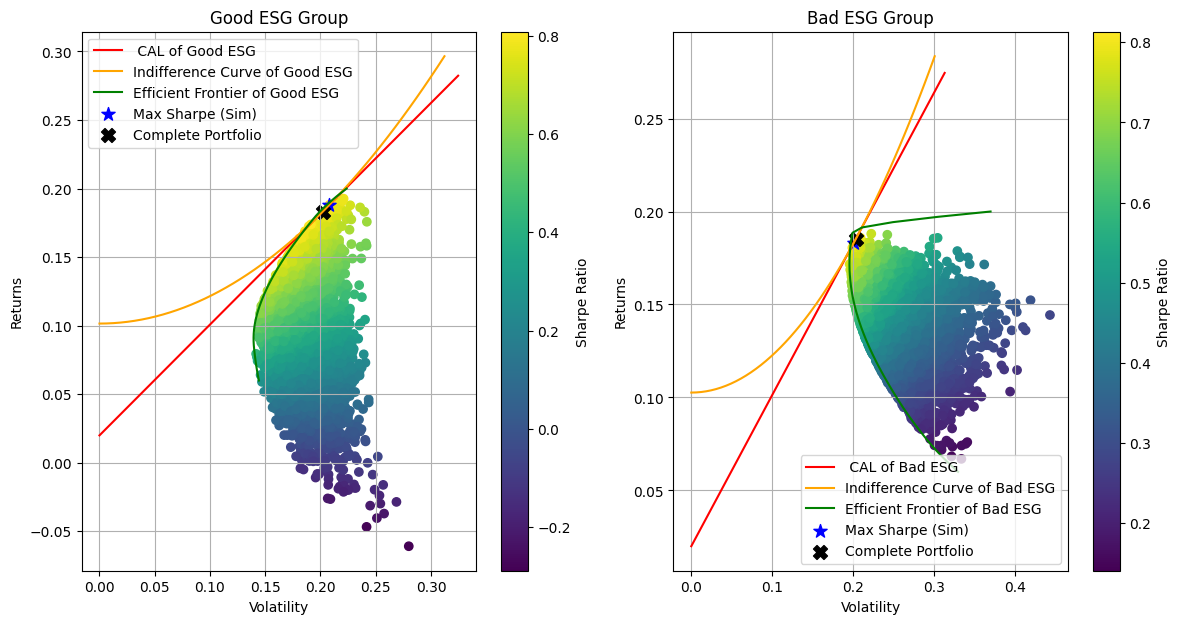

In [ ]:
# Drawing CAL lines, indifference curves, efficient frontier and  Complete Portfolios
import numpy as np


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

rf = 0.02
A = 4 #risk Aversion const

sharpe_good = optimal_sim_good['Sharpe Ratio']
sharpe_bad = optimal_sim_bad['Sharpe Ratio']

return_p_good = optimal_sim_good['Return']
return_p_bad = optimal_sim_bad['Return']

std_p_good = optimal_sim_good['StdDev']
std_p_bad = optimal_sim_bad['StdDev']

U_good = return_p_good - (0.5 * A * std_p_good**2)
U_bad = return_p_bad - (0.5 * A * std_p_bad**2)


cal_x_good = []
cal_y_good = []
cal_x_bad = []
cal_y_bad = []
indif_x_good = []
indif_y_good = []
indif_x_bad = []
indif_y_bad = []


# CALs
for er in np.linspace(rf, return_p_good * 1.5 , 50):
  sd = (er - rf)/ sharpe_good
  cal_x_good.append(sd)
  cal_y_good.append(er)

for er in np.linspace(rf, return_p_bad * 1.5 , 50):
  sd = (er - rf)/ sharpe_bad
  cal_x_bad.append(sd)
  cal_y_bad.append(er)

#indifference Curves
for std in np.linspace(0, std_p_good * 1.5 , 50):
  er = U_good + 0.5 * A * std**2
  indif_x_good.append(std)
  indif_y_good.append(er)

for std in np.linspace(0, std_p_bad * 1.5 , 50):
  er = U_bad + 0.5 * A * std**2
  indif_x_bad.append(std)
  indif_y_bad.append(er)



#construct complete portfolio
ystar_good = (return_p_good - rf) / A / std_p_good**2
ystar_bad = (return_p_bad - rf) / A / std_p_bad**2

return_c_good = ystar_good * return_p_good + (1 - ystar_good) * rf
std_c_good = ystar_good * std_p_good

return_c_bad = ystar_bad * return_p_bad + (1 - ystar_bad) * rf
std_c_bad = ystar_bad * std_p_bad

print(f"Complete Portfolio of Good ESG:\n"
      f"Optimal y*: {ystar_good:.4f}\n"
      f"Expected Return: {return_c_good:.4f}\n"
      f"Standard Deviation: {std_c_good:.4f}")

print(f"\nComplete Portfolio of Bad ESG:\n"
      f"Optimal y*: {ystar_bad:.4f}\n"
      f"Expected Return: {return_c_bad:.4f}\n"
      f"Standard Deviation: {std_c_bad:.4f}")

scatter_good = ax1.scatter(
    portfolios_good['StdDev'],
    portfolios_good['Return'],
    c=portfolios_good['Sharpe Ratio'],
    cmap='viridis',
    marker='o'
)
ax1.plot(cal_x_good, cal_y_good, color='red', label=' CAL of Good ESG')
ax1.plot(indif_x_good, indif_y_good, color='orange', label='Indifference Curve of Good ESG')
ax1.plot(frontier_x_good, frontier_y_good, color='green', label='Efficient Frontier of Good ESG')
ax1.scatter(optimal_sim_good['StdDev'], optimal_sim_good['Return'],
      color='blue', marker='*', s=100, label='Max Sharpe (Sim)')
ax1.scatter(std_c_good, return_c_good, color='black', marker='X', s=100, label='Complete Portfolio')
ax1.set_title('Good ESG Group')
ax1.set_xlabel('Volatility')
ax1.set_ylabel('Returns')
ax1.grid(True)
ax1.legend()

# Plot for Bad ESG Group
scatter_bad = ax2.scatter(
    portfolios_bad['StdDev'],
    portfolios_bad['Return'],
    c=portfolios_bad['Sharpe Ratio'],
    cmap='viridis',
    marker='o'
)
ax2.plot(cal_x_bad, cal_y_bad, color = 'red', label=' CAL of Bad ESG')
ax2.plot(indif_x_bad, indif_y_bad, color='orange', label='Indifference Curve of Bad ESG')
ax2.plot(frontier_x_bad, frontier_y_bad, color='green', label='Efficient Frontier of Bad ESG')
ax2.scatter(optimal_sim_bad['StdDev'], optimal_sim_bad['Return'],
      color='blue', marker='*', s=100, label='Max Sharpe (Sim)')
ax2.scatter(std_c_bad, return_c_bad, color='black', marker='X', s=100, label='Complete Portfolio')
ax2.set_title('Bad ESG Group')
ax2.set_xlabel('Volatility')
ax2.set_ylabel('Returns')
ax2.grid(True)
ax2.legend()

# Add color bar to show Sharpe Ratio scale
fig.colorbar(scatter_good, ax=ax1, label='Sharpe Ratio')
fig.colorbar(scatter_bad, ax=ax2, label='Sharpe Ratio')

plt.show()

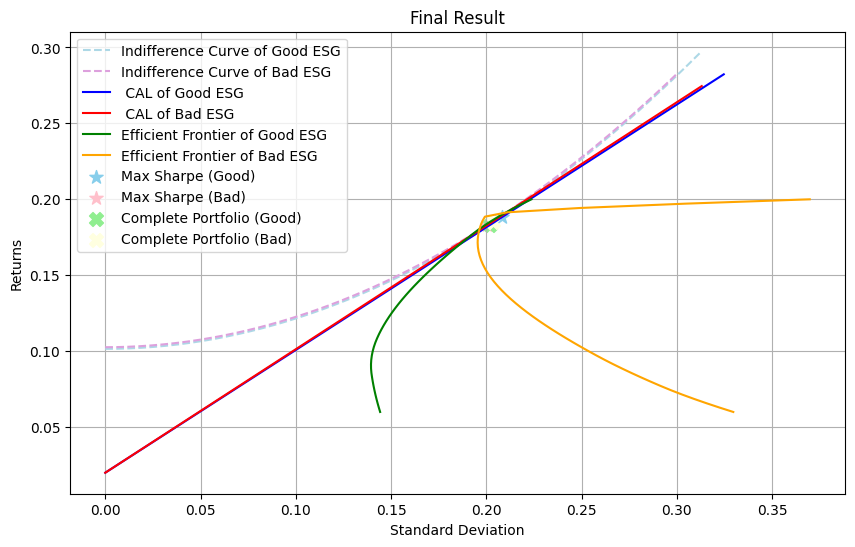

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
import pandas as pd

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(indif_x_good, indif_y_good, color='lightblue',linestyle='--', label='Indifference Curve of Good ESG')
ax.plot(indif_x_bad, indif_y_bad, color='plum',linestyle='--', label='Indifference Curve of Bad ESG')

ax.plot(cal_x_good, cal_y_good, color= 'blue', label=' CAL of Good ESG')
ax.plot(cal_x_bad, cal_y_bad, color= 'red', label=' CAL of Bad ESG')


ax.plot(frontier_x_good, frontier_y_good, color='green', label='Efficient Frontier of Good ESG')
ax.plot(frontier_x_bad, frontier_y_bad, color='orange', label='Efficient Frontier of Bad ESG')

ax.scatter(optimal_sim_good['StdDev'], optimal_sim_good['Return'],
      color='skyblue', marker='*', s=100, label='Max Sharpe (Good)')
ax.scatter(optimal_sim_bad['StdDev'], optimal_sim_bad['Return'],
      color='pink', marker='*', s=100, label='Max Sharpe (Bad)')

ax.scatter(std_c_good, return_c_good, color='lightgreen', marker='X', s=100, label='Complete Portfolio (Good)')
ax.scatter(std_c_bad, return_c_bad, color='lightyellow', marker='X', s=100, label='Complete Portfolio (Bad)')

ax.set_title('Final Result')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Returns')
ax.grid(True)
ax.legend()
